In [1]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')  # Suppresses gensim errors
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from util import get_distance, process_word, valid_page, get_samples

### Things I've installed:
1. wikipedia (query wikipedia) - not used
2. pywikibot (more advanced queries)
3. wikiutils (read sql.gz files) - not yet used. possibly in the future
4. gensim (for NLP and specifically using Google's word2vec)

### Load word2vec embeddings and connect to Wikipedia

In [2]:
# Obviously override this to your local location
model_addr = '/Users/benjaminrafetto/Code/cs182/project/data/GoogleNews-vectors-negative300.bin'

# claire's address 
# model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

model = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)
site = pywikibot.Site("en", "wikipedia")

## Add Greedy with randomized bad steps

## Search Algorithms

In [3]:
def greedy_word2vec(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if valid_page(p.title()):
                if p.title() not in visited:
                    visited.append(p.title())
                    processed = process_word(p.title(), model, combine_phrases)
                    distance = get_distance(processed, model, goal_list, distance_metric)
                    fringe.put((distance, p))

    return []

## A* in pure embedding space

In [4]:
# def a_star_search(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True):
#     start_list = process_word(start, model, combine_phrases)
#     goal_list = process_word(goal, model, combine_phrases)
#     assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
#     start_page = pywikibot.Page(site, start)
#     path = []
#     visited = []
#     fringe = queue.PriorityQueue()
#     embed_distance = get_distance(start_list, model, goal_list, distance_metric)
#     fringe.put((embed_distance, start_page, [], 0.0, embed_distance, start_list))
    
#     i = 0
#     while i < maxIters and not fringe.empty():
#         i += 1
#         priority, page, path, d_start, d_heuristic, page_processed = fringe.get()
#         path.append(page.title())
#         if verbose:
#             print("Exploring node {} with priority {} and path {}".format(page.title(), priority, path))
#         if goal.lower() == page.title().lower():
#             return path

#         for p in page.linkedPages():
#             if valid_page(p.title()):
#                 if p.title() not in visited:
#                     visited.append(p.title())
#                     processed = process_word(p.title(), model, combine_phrases)
#                     step_distance = get_distance(processed, model, page_processed, distance_metric)
#                     goal_distance = get_distance(processed, model, goal_list, distance_metric)
#                     fringe.put((d_start + step_distance + goal_distance, p, path, d_start + step_distance, goal_distance, processed))
    
#     return path, fringe

## A* taking into account path length

In [4]:
def a_star_search(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True, distance_multiplier=100.0):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    embed_distance = get_distance(start_list, model, goal_list, distance_metric)
    fringe.put((embed_distance, start_page, [], 0.0, embed_distance, start_list))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page, path, d_start, d_heuristic, page_processed = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with priority {} and path {}".format(page.title(), priority, path))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if valid_page(p.title()):
                if p.title() not in visited:
                    visited.append(p.title())
                    processed = process_word(p.title(), model, combine_phrases)
                    step_distance = get_distance(processed, model, page_processed, distance_metric)
                    goal_distance = get_distance(processed, model, goal_list, distance_metric)
                    fringe.put((len(path) + goal_distance * distance_multiplier, p, path, len(path) + 1, goal_distance * distance_multiplier, processed))
    
    return []

In [6]:
# start, goal = "speech", "lacrosse"
# start, goal = "War of 1812", "Queens of the Stone Age"

# path = a_star_search(start, goal, maxIters=100, verbose=False)
# path = greedy_word2vec_path(start, goal, maxIters=100, verbose=False)

### Generate data for greedy search:

In [16]:
examples = get_samples(50)

In [17]:
def run_search(search_method, search_tuples, **kwargs):
    results = {}
    for start, goal in tqdm(search_tuples):
        results[(start, goal)] = search_method(start, goal, **kwargs)
    return_results

In [18]:
results = run_search(greedy_word2vec, examples, maxIters=50, verbose=False, distance_metric="combined", combine_phrases=True)

100%|██████████| 50/50 [03:16<00:00,  3.93s/it]


NameError: name 'return_results' is not defined

In [ ]:
# pickle.dump(results, open('results/astar_phrase_combined_exclusions.pkl', 'wb'))

In [91]:
results_astar_exclusions = pickle.load( open( "results/astar_phrase_combined_exclusions.pkl", "rb" ) )

In [26]:
results_combined_exclusions = pickle.load( open( "results/greedy_phrase_combined_exclusions.pkl", "rb" ) )
results_combined = pickle.load( open( "results/greedy_phrase_combined.pkl", "rb" ) )
results_average = pickle.load( open( "results/greedy_phrase_average.pkl", "rb" ) )
results_minimum = pickle.load( open( "results/greedy_phrase_minimum.pkl", "rb" ) )
results_combined_words = pickle.load( open( "results/greedy_words_combined.pkl", "rb" ) )
results_minimum_words = pickle.load( open( "results/greedy_words_minimum.pkl", "rb" ) )
results_average_words = pickle.load( open( "results/greedy_words_average.pkl", "rb" ) )

# Make sure average doesn't have old values

In [11]:
def plot_results(result_list, label_list, title='Kernel density estimation of path lengths for greedy search', save_to_file=None):
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    num_fail = {}

    for data, label in zip(result_list, label_list):
        lengths = []
        num_fail[label] = 0
        for k, v in data.items():
            if len(v) > 0:
                lengths.append(len(v))
            else:
                num_fail[label]+=1
        sns.distplot(lengths, kde=True, hist=False, label=label, rug=True)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title);  # FYI this semi-colon is magic.
    
    if save_to_file:
        fig.savefig(save_to_file)
    
    return num_fail

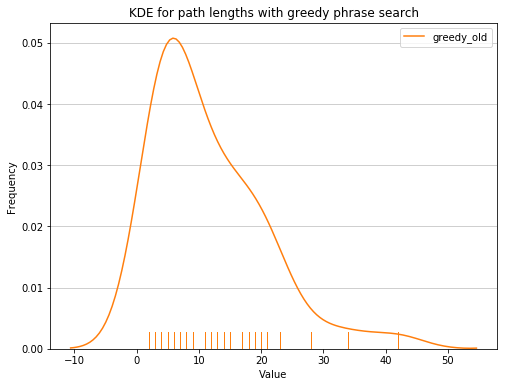

In [74]:
numfail_phrase = plot_results([results, results_old], ['greedy', 'greedy_old'],
             title="KDE for path lengths with greedy phrase search")

In [43]:
total = []
for k, v in results:
    total.append(len(v))

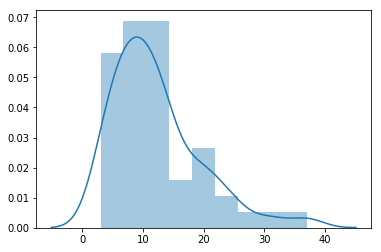

In [42]:
sns.distplot(total)

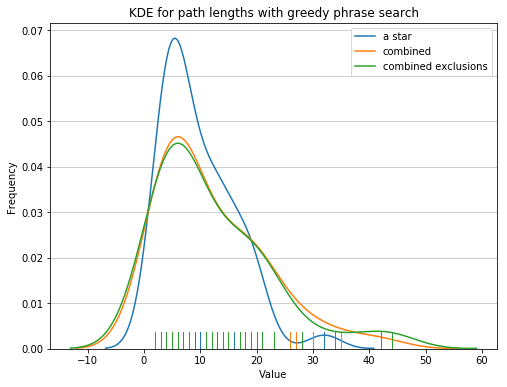

In [93]:
numfail_phrase = plot_results([results_astar_exclusions, results_combined, results_combined_exclusions], ['a star', 'combined', 'combined exclusions'],
             title="KDE for path lengths with greedy phrase search", save_to_file="astar.png")

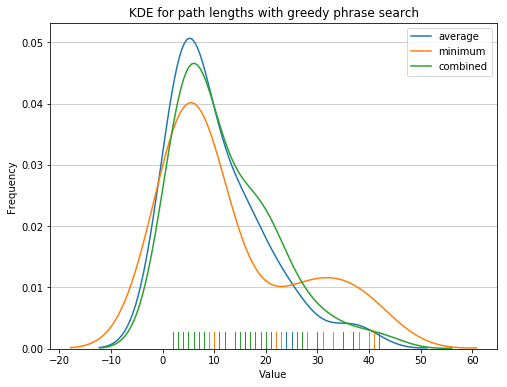

In [5]:
numfail_phrase = plot_results([results_average, results_minimum, results_combined], ['average', 'minimum', 'combined'],
             title="KDE for path lengths with greedy phrase search", save_to_file="kde_phrases.png")

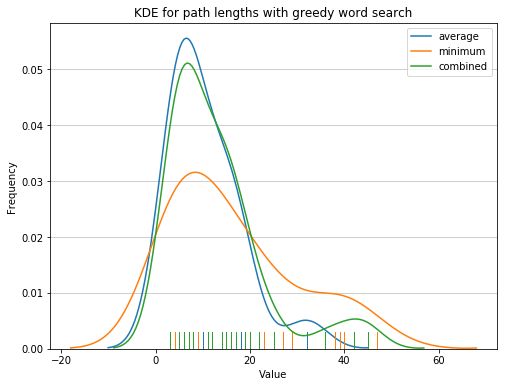

In [6]:
numfail_word = plot_results([results_average_words, results_minimum_words, results_combined_words],
             ['average', 'minimum', 'combined'], title="KDE for path lengths with greedy word search",
             save_to_file="kde_words.png")

In [7]:
display(numfail_word)
display(numfail_phrase)

{'average': 32, 'combined': 11, 'minimum': 19}

{'average': 28, 'combined': 5, 'minimum': 15}

In [9]:
full_data = {'phrase average': 28,'word average': 32,  
              'word minimum': 19,'word combined': 11,'phrase minimum': 15,'phrase combined': 5}
import pandas as pd
df = pd.DataFrame.from_dict(list(full_data.items()))
df.columns = ['algorithm','num_failed']
df

,algorithm,num_failed
0,phrase average,28
1,word average,32
2,word minimum,19
3,word combined,11
4,phrase minimum,15
5,phrase combined,5


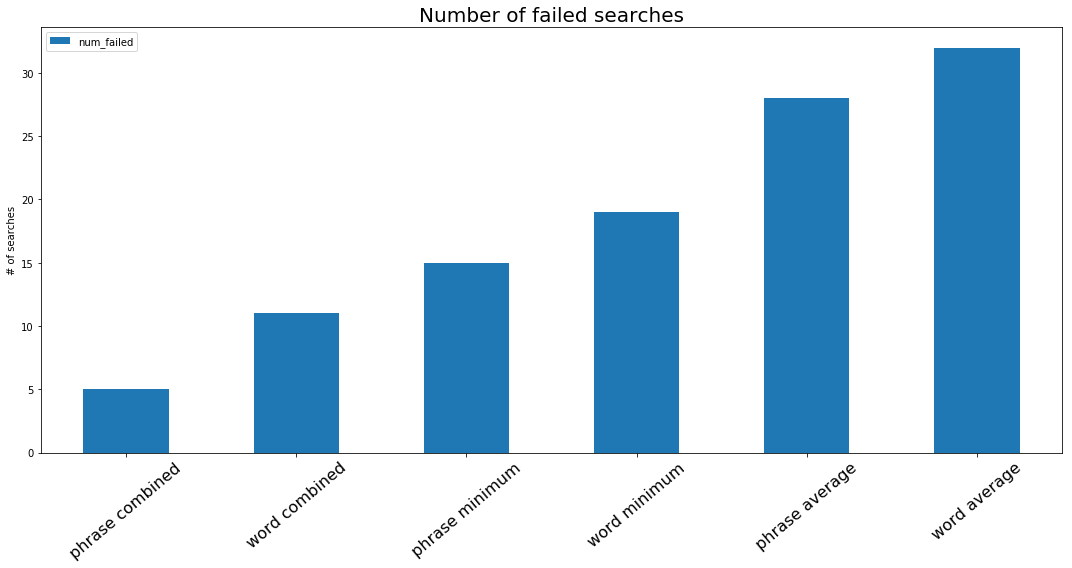

In [20]:
df = df.sort_values(by='num_failed', ascending=True)
df.plot.bar(stacked=False, figsize=(15,8))
plt.xticks(rotation=40, fontsize=16)
plt.title("Number of failed searches", fontsize=20)
plt.ylabel('# of searches')
plt.xticks(np.arange(6), df['algorithm'])
plt.tight_layout()
plt.savefig("failed_searches_correct.png")
plt.show()
